In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

# Initial setup

In [2]:
df = pd.read_csv("data/daily_sales_french_bakery.csv", parse_dates=["ds"])
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df = df.drop(["unit_price"], axis=1)
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


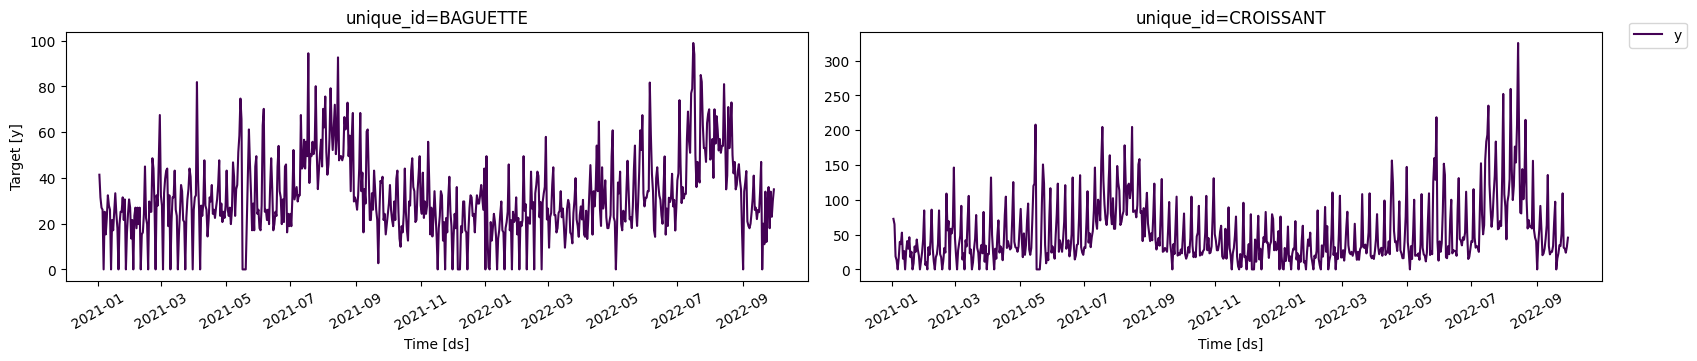

In [3]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], palette="viridis")

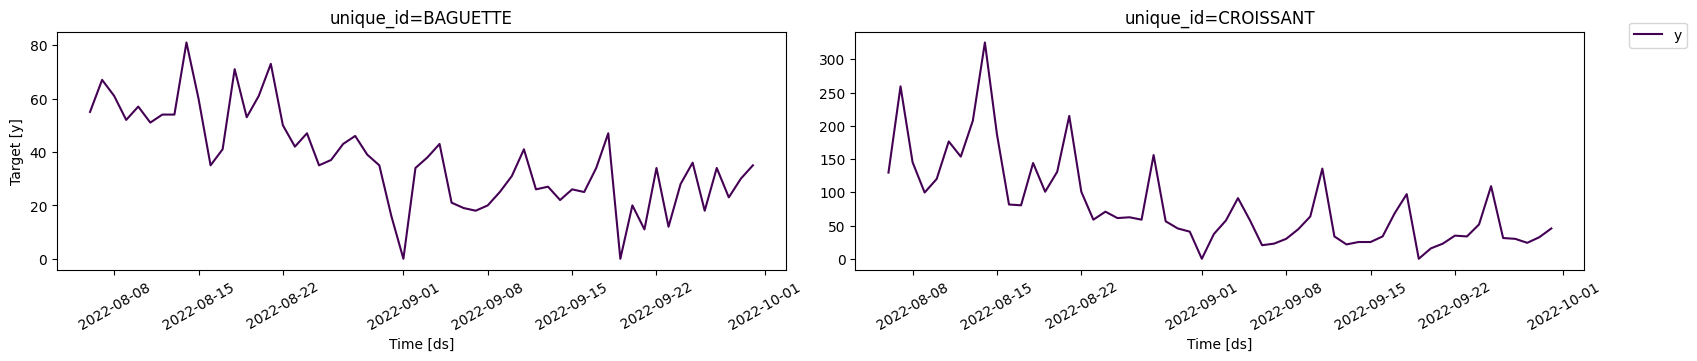

In [4]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")

# Baseline Models

In [5]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [6]:
horizon = 7

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=df)
preds = sf.predict(h=horizon)

In [7]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


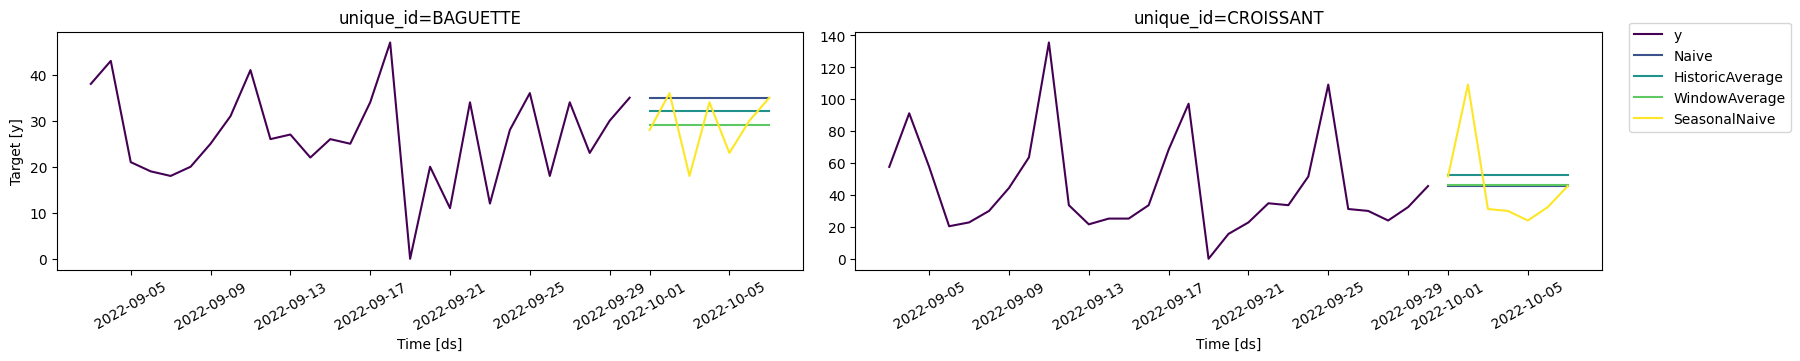

In [8]:
plot_series(
    df=df, 
    forecasts_df=preds, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28 , 
    palette="viridis")

# Evaluate baseline models

In [9]:
test = df.groupby("unique_id").tail(7) ## 표의 라스트 7일치를 미리 빼놓아서 test데이터로 지정
train = df.drop(test.index).reset_index(drop=True) ## 모든 데이터에서 test데이터를 뺀 데이터를 train으로 지정 
test.head()

,unique_id,ds,y
71,12 MACARON,2022-09-22,0.0
72,12 MACARON,2022-09-23,0.0
73,12 MACARON,2022-09-24,10.0
74,12 MACARON,2022-09-25,0.0
75,12 MACARON,2022-09-26,0.0


In [10]:
sf.fit(df=train) ## train을 모델에 학습
preds = sf.predict(h = horizon) ## 해당 모델이 그 후의 7일만큼의 예측값을 제시
eval_df = pd.merge(test,preds,'left',['ds','unique_id']) ## test와 preds를 병합
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-22,0.0,9.577465,1.428571,10.0
1,12 MACARON,2022-09-23,0.0,9.577465,1.428571,0.0
2,12 MACARON,2022-09-24,0.0,9.577465,1.428571,0.0
3,12 MACARON,2022-09-25,0.0,9.577465,1.428571,0.0
4,12 MACARON,2022-09-26,0.0,9.577465,1.428571,0.0


In [11]:
evaluation = evaluate(
    eval_df,
    metrics=[mae],
) ## 각 모델의 평균 오차를 계산
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [12]:
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index() ## 전체 데이터의 평균 계산
evaluation ## 값이 0에 가까울수록 정확도가 높음

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


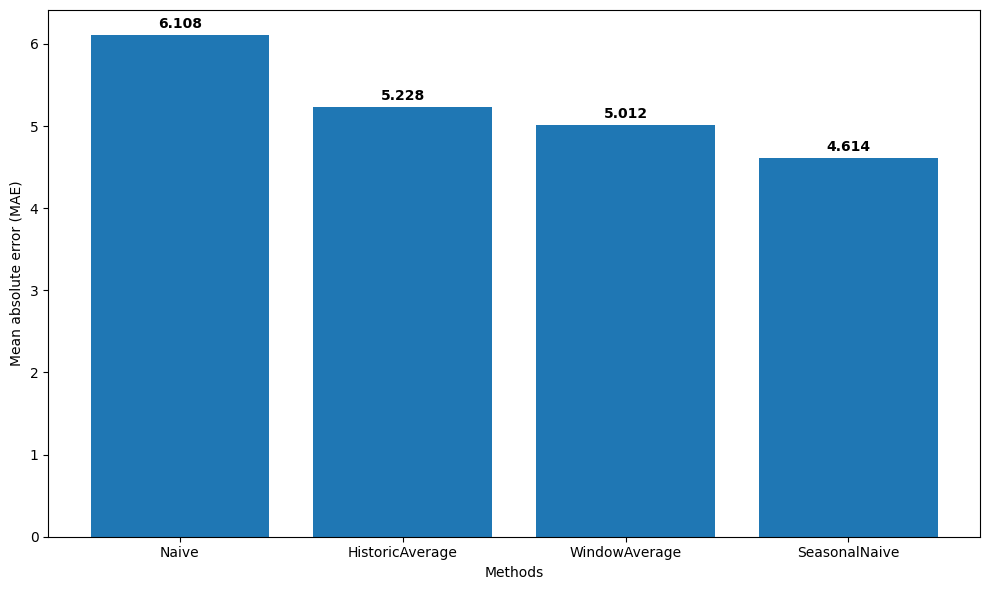

In [13]:
methods = evaluation.columns[1:].tolist()  
values = evaluation.iloc[0, 1:].tolist() 

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()


In [14]:
from statsforecast.models import AutoARIMA 
## AR : 자기회귀모형 = 현재의 사건이 몇개의 과거 사건의 영향을 받았는가
### 자기상관함수와 편자기상관함수을 이용하여 AR을 식별 (시차가 증가 -> 자기상관함수 서서히 감소, 편자기상관함수는 급격히 감소)
#### 자기상관함수 : 시간의 경과에 따른 값들 사이의 상관관계를 측정하는 함수
#### 편자기상관함수 : 경과에 따른 값들을 지우고 오로지 끝과 끝의 사건만의 상관관계를 측정하는 함수

## MR : 이동평균모델 = 과거의 충격이 현재의 값에 영향을 줄때

In [15]:
unique_ids = ["BAGUETTE", "CROISSANT"]

##train = df.drop(test.index).reset_index(drop=True) ## 모든 데이터에서 test데이터를 뺀 데이터를 train으로 지정 
small_train = train[train["unique_id"].isin(unique_ids)] ##unique_ids 와 일치하는 것들
##test = df.groupby("unique_id").tail(7) ## 표의 라스트 7일치를 미리 빼놓아서 test데이터로 지정
small_test = test[test["unique_id"].isin(unique_ids)]

models = [
    AutoARIMA(seasonal=False, alias="ARIMA"), ## 계절성 무시
    AutoARIMA(season_length=7, alias="SARIMA") ## 7일주기의 계절성까지 모두 고려
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae],
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353153,7.449083,17.142857,5.455193,7.877551,12.571429
1,CROISSANT,mae,14.565395,10.359143,17.485714,22.618934,18.244898,12.857143


In [16]:
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,11.959274,8.904113,17.314286,14.037063,13.061224,12.714286


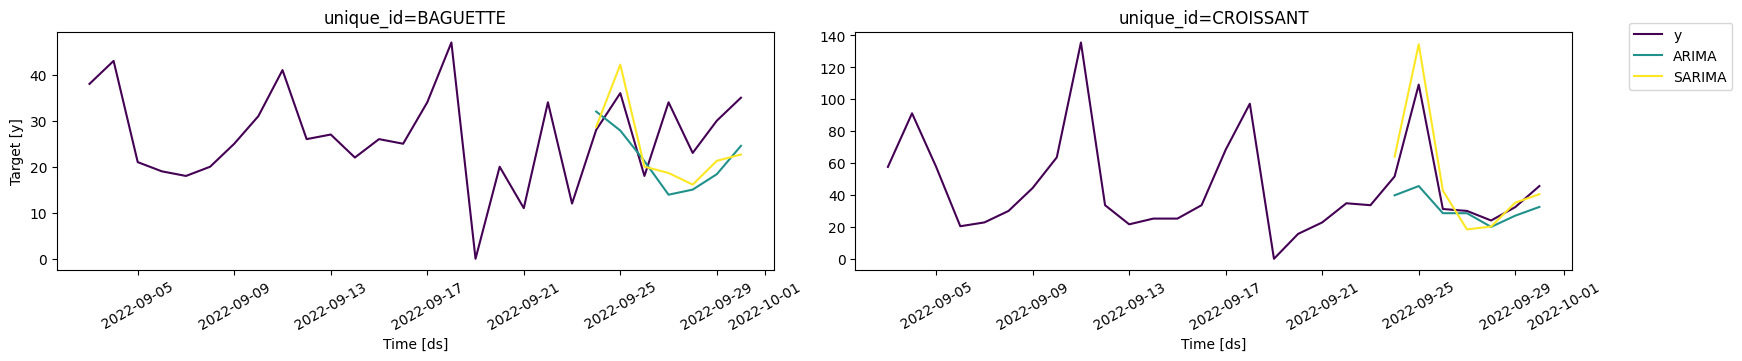

In [17]:
plot_series(
    df=df, 
    forecasts_df=arima_preds, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28, 
    palette="viridis")

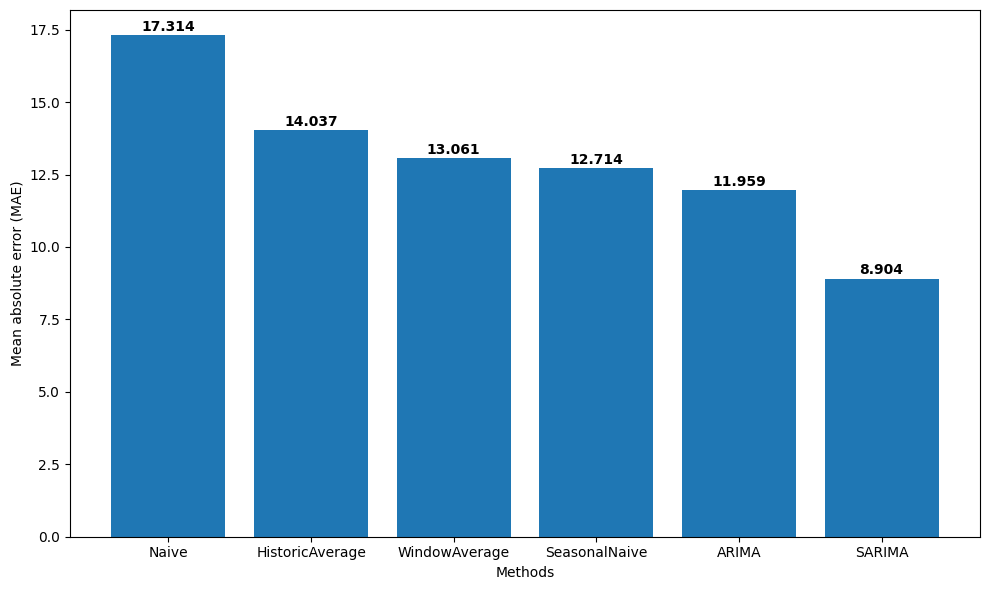

In [18]:
methods = arima_eval.columns[1:].tolist()  
values = arima_eval.iloc[0, 1:].tolist() 

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

# Cross-validation

In [21]:
small_df = df[df['unique_id'].isin(unique_ids)] ## unique_ids = ["BAGUETTE", "CROISSANT"]

models = [
    SeasonalNaive(season_length=7),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")

cv_df = sf.cross_validation(
    h=horizon,
    df = small_df,
    n_windows=8, ## 총 8번 검증
    step_size=horizon,## 7일씩 추가 = 마지막날부터 총 56일의 데이터가 테스트 데이터로 쓰임
    refit=True
)
cv_df.head() ## ds = 예측한 날짜, cutoff = 해당 날짜까지 학습데이터로 씀, y = 실제 값 

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,2022-08-06,2022-08-05,55.0,68.0,71.355196,71.584713
1,BAGUETTE,2022-08-07,2022-08-05,67.0,70.0,70.337980,78.458883
2,BAGUETTE,2022-08-08,2022-08-05,61.0,48.0,61.195004,57.001732
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.0,52.649013,49.401144
4,BAGUETTE,2022-08-10,2022-08-05,57.0,57.0,47.785876,49.725278


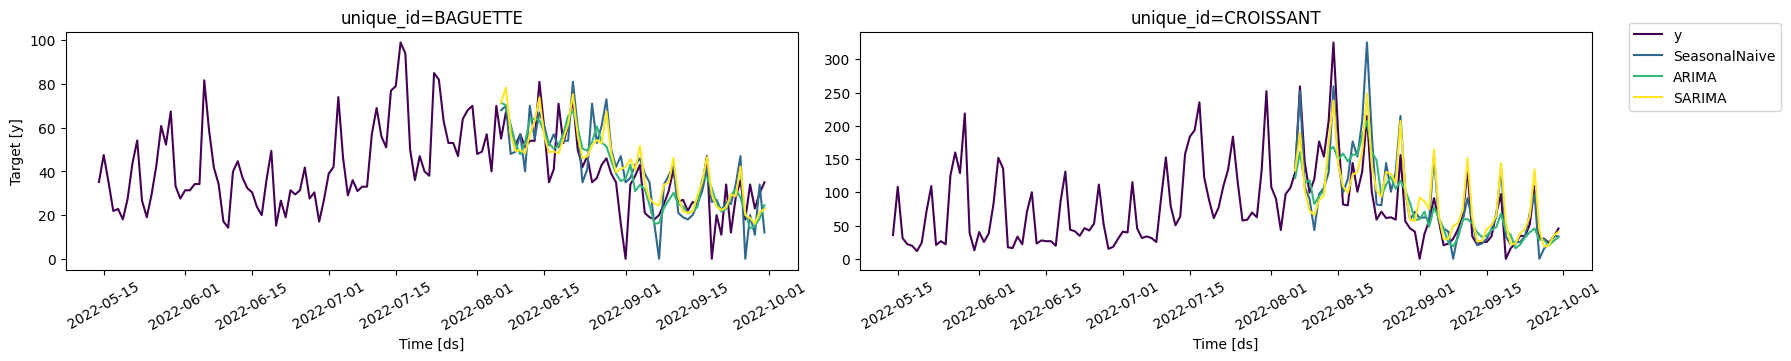

In [22]:
plot_series(
    df = small_df,
    forecasts_df = cv_df.drop(["y","cutoff"],axis = 1),
    ids = ["BAGUETTE","CROISSANT"],
    max_insample_length=140,
    palette="viridis"
)


In [25]:
cv_eval = evaluate(
    cv_df.drop(["cutoff"],axis=1),
    metrics=[mae]
)
cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_eval

,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,21.117857,21.17093,19.281296


['SeasonalNaive', 'ARIMA', 'SARIMA']
[np.float64(21.11785714285714), np.float64(21.170930362109775), np.float64(19.28129567507205)]
-0.4 0.4 21.11785714285714
0.6 0.4 21.170930362109775
1.6 0.4 19.28129567507205


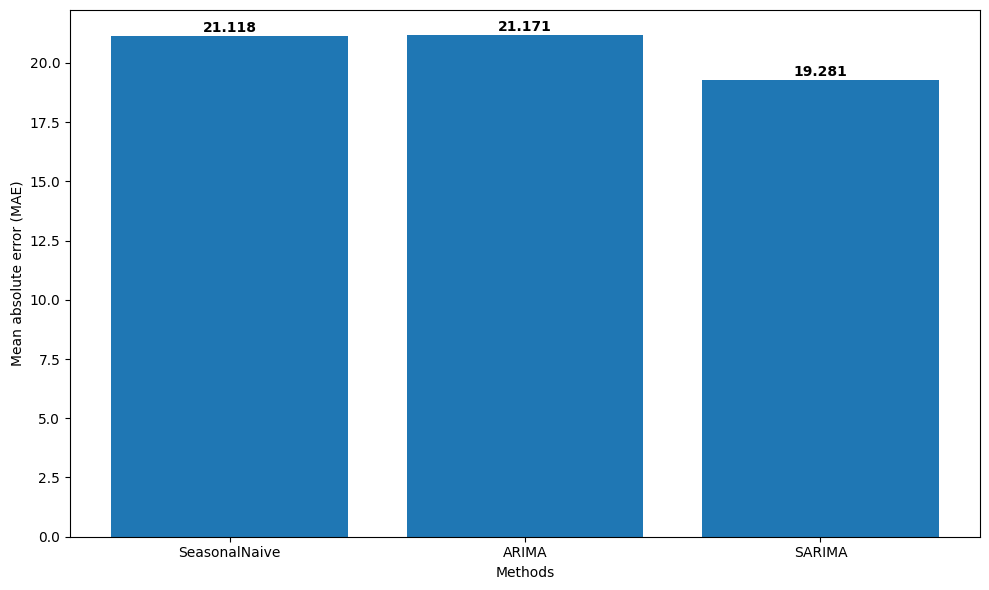

In [30]:
methods = cv_eval.columns[1:].tolist()
print(methods)
values = cv_eval.iloc[0, 1:].tolist()
print(values)

plt.figure(figsize=(10,6))
bars = plt.bar(methods,values)

for bar,value in zip(bars,values):
    print(bar.get_x(), bar.get_width()/2,bar.get_height())
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

# Forecasting with exogenous features